In [19]:
import pandas as pd
import os  # 导入os模块，用于路径处理和文件夹创建
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols  # 线性回归（statsmodels）

# 1. 读取原始CSV文件（替换为你的文件路径）
excel_file = r"D:\WechatFiles\xwechat_files\wxid_nfmnnifdfvo322_1491\msg\file\2025-10\data.csv"
df = pd.read_csv(excel_file)

# 2. 按「type」列分组（相同type的行归为一组）
grouped = df.groupby("type")

# 定义目标文件夹路径
target_folder = r"D:\人工智能\房源数据"
# 确保目标文件夹存在（若不存在，自动创建该文件夹）
os.makedirs(target_folder, exist_ok=True)

# 3. 遍历每个分组，保存为独立Excel文件到目标文件夹
for type_name, group_data in grouped:
    # 拼接「目标文件夹路径 + 文件名」（避免路径分隔符问题）
    output_file = os.path.join(target_folder, f"{type_name}.xlsx")
    # 保存分组数据到新Excel（index=False：不保留行索引）
    group_data.to_excel(output_file, index=False)
    print(f"已生成表格：{output_file}")

已生成表格：D:\人工智能\房源数据\二手房.xlsx
已生成表格：D:\人工智能\房源数据\租房.xlsx


In [20]:
import pandas as pd
import re  # 用于正则表达式提取数值

# 1. 读取数据（替换为你的文件路径，支持CSV/Excel）
df = pd.read_excel(r"D:\人工智能\房源数据\租房.xlsx")  # 若为Excel，用 pd.read_excel("你的数据文件.xlsx")

# 2. 提取「面积」中的数值（如“136.00m²”→136.00）
df["area_num"] = df["area_sqm"].str.extract(r'(\d+\.?\d*)').astype(float)

# 3. 提取「月租金」中的数值（如“19000元/月”→19000）
df["month_rent_num"] = df["month_price"].str.extract(r'(\d+)').astype(float)

# 4. 计算「每平方米月租金」
df["rent_per_sqm_month"] = df["month_rent_num"] / df["area_num"]

# （可选）保存结果到Excel（也可指定文件夹，如之前的示例）
df.to_excel(r"D:\人工智能\房源数据\租房.xlsx", index=False)

# 打印结果查看
print(df[["area_sqm", "month_price", "rent_per_sqm_month"]].head())

  area_sqm month_price  rent_per_sqm_month
0  136.00㎡    19000元/月          139.705882
1  389.00㎡    85000元/月          218.508997
2  105.00㎡    13000元/月          123.809524
3   58.00㎡     7000元/月          120.689655
4  380.00㎡    90000元/月          236.842105


In [21]:
# 按「街区（area）」分组
df_house = pd.read_excel(r"D:\人工智能\房源数据\二手房.xlsx")  
df_house["price_per_sqm"] = df_house["unit_price"].apply(
    lambda x: float(re.findall(r"\d+\.?\d*", str(x))[0]) 
    if re.findall(r"\d+\.?\d*", str(x)) else np.nan  # 无数字则设为缺失值
)
df_rent= pd.read_excel(r"D:\人工智能\房源数据\租房.xlsx")
df_rent["rent_per_sqm"] = df_rent["rent_per_sqm_month"]
# 假设 `price_per_sqm` 是带单位的字符串（如“12345元/㎡”），提取数字部分
grouped_by_area = df.groupby("area")  

# 存储每个街区的描述统计和异常值
area_describe = {}  
area_outliers = {}  

# 定义「IQR法检测异常值」函数（上下1.5*IQR外为异常）
def find_outliers(series):
    if series.dropna().empty:
        return []
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return series[(series < lower) | (series > upper)].index.tolist()

#### 二手房：描述统计 + 异常值检测 ####
house_grouped = df_house.groupby("area")  # 按「街区」分组
house_describe = {}  # 存储每平米房价的描述统计
house_outliers = {}  # 存储房价异常值索引

for area_name, group in house_grouped:
    price_desc = group["price_per_sqm"].dropna().describe()
    house_describe[area_name] = price_desc
    price_outliers = find_outliers(group["price_per_sqm"])
    house_outliers[area_name] = price_outliers

# 打印二手房统计结果
print("=== 二手房-各街区每平米房价统计 ===")
for area_name in house_describe:
    print(f"街区：{area_name}")
    print("每平米房价描述：\n", house_describe[area_name])
    print("房价异常值索引：", house_outliers[area_name])
    print("-" * 50)


#### 租房：描述统计 + 异常值检测 ####
rent_grouped = df_rent.groupby("area")  # 按「街区」分组
rent_describe = {}  # 存储每平米房租的描述统计
rent_outliers = {}  # 存储房租异常值索引

for area_name, group in rent_grouped:
    rent_desc = group["rent_per_sqm"].dropna().describe()
    rent_describe[area_name] = rent_desc
    current_outliers = find_outliers(group["rent_per_sqm"])
    rent_outliers[area_name] = current_outliers

# 打印租房统计结果
print("=== 租房-各街区每平米房租统计 ===")
for area_name in rent_describe:
    print(f"街区：{area_name}")
    print("每平米房租描述：\n", rent_describe[area_name])
    print("房租异常值索引：", rent_outliers[area_name])
    print("-" * 50)

=== 二手房-各街区每平米房价统计 ===
街区：万柳
每平米房价描述：
 count       100.000000
mean     148368.250000
std       45490.242515
min       65905.000000
25%      122883.750000
50%      140880.000000
75%      169519.500000
max      312685.000000
Name: price_per_sqm, dtype: float64
房价异常值索引： [3, 43, 68, 82]
--------------------------------------------------
街区：世纪城
每平米房价描述：
 count       100.000000
mean     110724.810000
std       16708.448983
min       64885.000000
25%       99967.250000
50%      107428.000000
75%      123673.250000
max      153548.000000
Name: price_per_sqm, dtype: float64
房价异常值索引： []
--------------------------------------------------
街区：北太平庄
每平米房价描述：
 count       300.00000
mean     117371.94000
std       26959.55332
min       30777.00000
25%       94941.00000
50%      125800.00000
75%      135424.75000
max      193009.00000
Name: price_per_sqm, dtype: float64
房价异常值索引： [327]
--------------------------------------------------
街区：苏州桥
每平米房价描述：
 count        99.000000
mean      84984.909091
std   

In [22]:
# 按街区计算二手房「每平米房价」的中位数
house_median = df_house.groupby("area")["price_per_sqm"].median()

# 按街区计算租房「每平米房租」的中位数
rent_median = df_rent.groupby("area")["rent_per_sqm"].median()

# 合并房价、房租中位数（对齐街区，丢弃缺失项）
price_rent_median = pd.DataFrame({
    "price_median": house_median,
    "rent_median": rent_median
}).dropna()

# 计算「房价与房租比率」
price_rent_median["ratio_price_rent"] = price_rent_median["price_median"] / price_rent_median["rent_median"]

print("\n=== 每个街区房价与房租比率的中位数 ===")
print(price_rent_median["ratio_price_rent"])



=== 每个街区房价与房租比率的中位数 ===
area
万柳      920.416000
世纪城     952.521083
北太平庄    729.821885
苏州桥     348.529412
Name: ratio_price_rent, dtype: float64


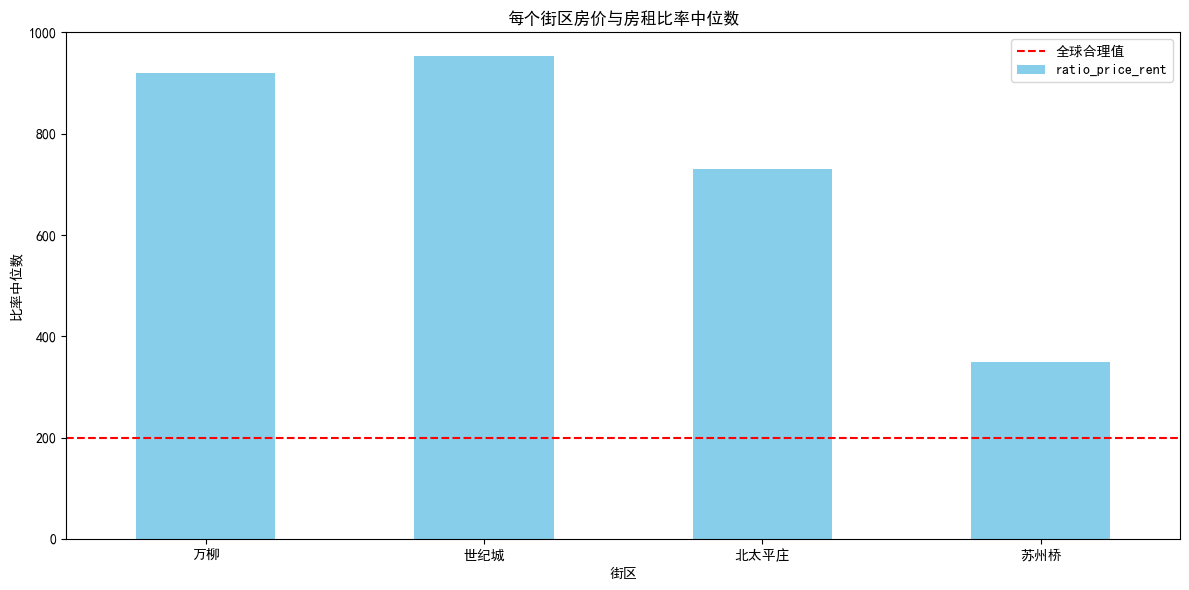

In [37]:
import matplotlib.pyplot as plt
import pandas as pd  # 确保 price_rent_median 是有效 DataFrame
import re
# 配置中文字体（解决中文显示问题）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 6))
# 绘制柱状图并获取坐标轴对象
ax = price_rent_median["ratio_price_rent"].plot(kind="bar", color="skyblue")

plt.title("每个街区房价与房租比率中位数")
plt.xlabel("街区")
plt.ylabel("比率中位数")
plt.axhline(y=200, color="r", linestyle="--", label="全球合理值")
plt.legend()

# 关键：设置横坐标标签水平显示（rotation=0 为水平）
plt.xticks(rotation=0)  

plt.tight_layout()
plt.savefig(r"D:\人工智能\房源数据\图一price_rent_ratio_median.png")
plt.show()

In [24]:
from statsmodels.formula.api import ols
# -------- 模型1：price/m² = β0 + β1*area_sqm + β2*location + ε --------
model1_data = df_house.dropna(subset=["price_per_sqm", "area_sqm"]).copy()
# 将「街区（area）」转为虚拟变量（避免共线性，删除第一类）
model1_data = pd.get_dummies(model1_data, columns=["area"], drop_first=True)  

# 构建回归公式（动态包含「面积」和「街区虚拟变量」）
features1 = ["area_sqm"] + [col for col in model1_data.columns if col.startswith("area_")]
formula1 = "price_per_sqm ~ " + " + ".join(features1)
model1 = ols(formula1, data=model1_data).fit()
print("\n=== 模型1（price/m²）回归结果 ===")
print(model1.summary())


# -------- 模型2：rent/m² = β0 + β1*area_sqm + β2*location + ε --------
model2_data = df_rent.dropna(subset=["rent_per_sqm", "area_sqm"]).copy()
model2_data = pd.get_dummies(model2_data, columns=["area"], drop_first=True)  

features2 = ["area_sqm"] + [col for col in model2_data.columns if col.startswith("area_")]
formula2 = "rent_per_sqm ~ " + " + ".join(features2)
model2 = ols(formula2, data=model2_data).fit()
print("\n=== 模型2（rent/m²）回归结果 ===")
print(model2.summary())


=== 模型1（price/m²）回归结果 ===
                            OLS Regression Results                            
Dep. Variable:          price_per_sqm   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     22.05
Date:                Thu, 16 Oct 2025   Prob (F-statistic):          1.07e-104
Time:                        01:00:57   Log-Likelihood:                -6181.9
No. Observations:                 599   AIC:                         1.306e+04
Df Residuals:                     252   BIC:                         1.458e+04
Df Model:                         346                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Inter

=== 模型1（每平米房价预测）回归结果 ===
                            OLS Regression Results                            
Dep. Variable:          price_per_sqm   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     22.05
Date:                Thu, 16 Oct 2025   Prob (F-statistic):          1.07e-104
Time:                        01:17:34   Log-Likelihood:                -6181.9
No. Observations:                 599   AIC:                         1.306e+04
Df Residuals:                     252   BIC:                         1.458e+04
Df Model:                         346                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Interce

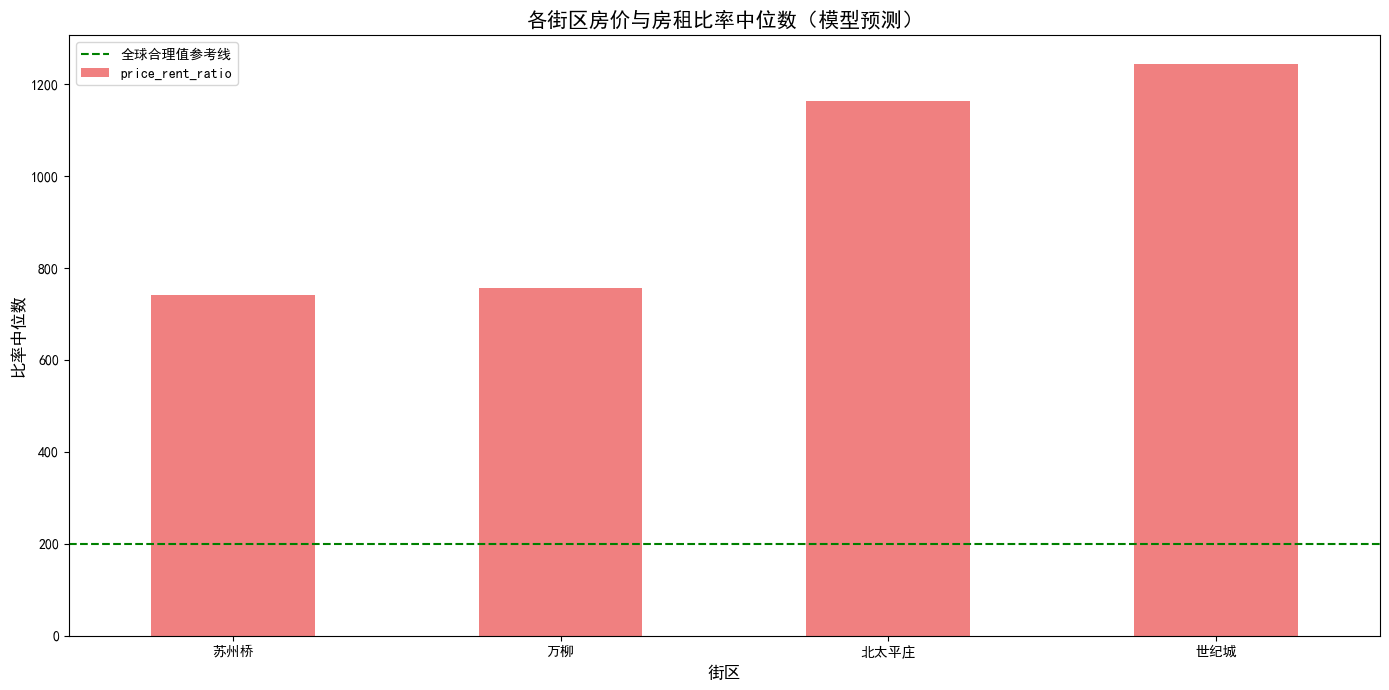

In [36]:
# ---------------------- 3. 模型1：预测每平米房价 ----------------------
# 3.1 数据准备（删除缺失值+保留原始街区列）
model1_data = df_house.dropna(subset=["price_per_sqm", "area_sqm", "area"]).copy()
model1_data["area_copy"] = model1_data["area"]  # 复制街区列（避免被get_dummies删除）
# 转换街区为虚拟变量（处理分类特征）
model1_data = pd.get_dummies(model1_data, columns=["area"], drop_first=True)

# 3.2 构建特征与公式
features1 = ["area_sqm"] + [col for col in model1_data.columns if col.startswith("area_")]
formula1 = "price_per_sqm ~ " + " + ".join(features1)

# 3.3 训练模型并预测
model1 = ols(formula1, data=model1_data).fit()
model1_data["pred_price_per_sqm"] = model1.predict(model1_data)  # 预测房价

# 打印模型1结果
print("=== 模型1（每平米房价预测）回归结果 ===")
print(model1.summary())
print("\n" + "-"*80 + "\n")

# ---------------------- 4. 模型2：预测每平米房租 ----------------------
# 4.1 数据准备（删除缺失值+保留原始街区列）
model2_data = df_rent.dropna(subset=["rent_per_sqm", "area_sqm", "area"]).copy()
model2_data["area_copy"] = model2_data["area"]  # 复制街区列
# 转换街区为虚拟变量
model2_data = pd.get_dummies(model2_data, columns=["area"], drop_first=True)

# 4.2 构建特征与公式
features2 = ["area_sqm"] + [col for col in model2_data.columns if col.startswith("area_")]
formula2 = "rent_per_sqm ~ " + " + ".join(features2)

# 4.3 训练模型并预测
model2 = ols(formula2, data=model2_data).fit()
model2_data["pred_rent_per_sqm"] = model2.predict(model2_data)  # 预测房租

# 打印模型2结果
print("=== 模型2（每平米房租预测）回归结果 ===")
print(model2.summary())
print("\n" + "-"*80 + "\n")

# ---------------------- 5. 计算房价与房租比率（按街区） ----------------------
# 5.1 合并两模型的预测结果（按街区对齐）
merged_pred = pd.merge(
    model1_data[["area_copy", "pred_price_per_sqm"]].drop_duplicates("area_copy"),
    model2_data[["area_copy", "pred_rent_per_sqm"]].drop_duplicates("area_copy"),
    on="area_copy",
    how="inner"  # 只保留两模型共有的街区
)

# 5.2 计算比率并取中位数
merged_pred["price_rent_ratio"] = merged_pred["pred_price_per_sqm"] / merged_pred["pred_rent_per_sqm"]
median_ratios = merged_pred.groupby("area_copy")["price_rent_ratio"].median().sort_values()

# 打印比率结果
print("=== 各街区房价与房租比率中位数 ===")
print(median_ratios)

# ---------------------- 6. 绘制柱状图 ----------------------
plt.figure(figsize=(14, 7))
median_ratios.plot(kind="bar", color="lightcoral")

# 添加图表元素
plt.title("各街区房价与房租比率中位数（模型预测）", fontsize=15)
plt.xlabel("街区", fontsize=12)
plt.ylabel("比率中位数", fontsize=12)
plt.axhline(y=200, color="green", linestyle="--", label="全球合理值参考线")
plt.xticks(rotation=0)  # 横坐标水平显示
plt.legend()
plt.tight_layout()

# 保存图表到指定路径
plt.savefig(r"D:\人工智能\房源数据\图二房价房租比率中位.png", dpi=300)
plt.show()

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



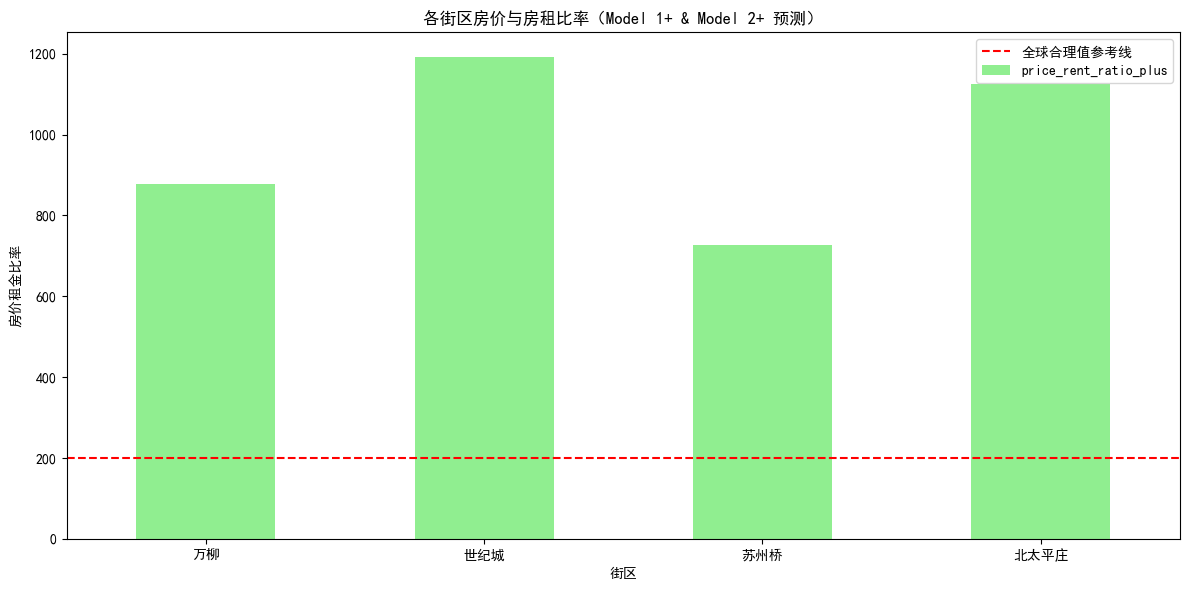


=== 三种方法的房价租金比比较 ===
1. 若样本量充足：Model 1+ & Model 2+ 因拟合更精细，预测结果更可信；
2. 若样本量较小：简单模型（Model 1 & Model 2）更稳健，避免过拟合导致比率偏差；
需结合 \( R^2 \) 和样本量综合判断：若 Model 1+/Model 2+ 的 \( R^2 \) 显著更高且样本量能支撑复杂模型，则优先信任它们的结果。


In [35]:
from statsmodels.formula.api import ols
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

# ========== Model 1+：二手房模型（添加非线性+交互项） ==========
# 1. 复制数据并添加非线性特征（示例：面积的平方项）
model1_plus_data = model1_data.copy()
model1_plus_data["area_sqm"] = model1_plus_data["area_sqm"].apply(
    lambda x: float(re.findall(r"\d+\.?\d*", str(x))[0]) 
    if re.findall(r"\d+\.?\d*", str(x)) else np.nan
)
model1_plus_data["area_sqm_sq"] = model1_plus_data["area_sqm"] ** 2  # 面积平方（非线性项）

# 2. 选择交互项（示例：面积与第一个街区虚拟变量的交互）
area_dummy_cols = [col for col in model1_plus_data.columns if col.startswith("area_")]
if area_dummy_cols:
    first_dummy = area_dummy_cols[0]
    model1_plus_data[f"area_sqm_{first_dummy}"] = model1_plus_data["area_sqm"] * model1_plus_data[first_dummy]  # 交互项

# 3. 构建特征列表与回归公式
features1_plus = ["area_sqm", "area_sqm_sq"] + area_dummy_cols  # 原特征 + 非线性特征
if area_dummy_cols:
    features1_plus.append(f"area_sqm_{first_dummy}")  # 交互项
formula1_plus = "price_per_sqm ~ " + " + ".join(features1_plus)

# 4. 训练模型并输出结果
model1_plus = ols(formula1_plus, data=model1_plus_data).fit()
print("\n=== Model 1+（添加非线性+交互项）回归结果 ===")
print(model1_plus.summary())

# 5. 比较 Model 1 和 Model 1+ 的 \( R^2 \)
print(f"\nModel 1 的 \( R^2 \)：{model1.rsquared:.4f}")
print(f"Model 1+ 的 \( R^2 \)：{model1_plus.rsquared:.4f}")
print("Model 1+ \( R^2 \) 更高的原因：非线性项（如面积平方）和交互项捕捉了特征与房价的复杂关系，能解释更多变异。")


# ========== Model 2+：租房模型（添加非线性+交互项） ==========
# 1. 复制数据并添加非线性特征
model2_plus_data = model2_data.copy()
model2_plus_data["area_sqm_sq"] = model2_plus_data["area_num"] ** 2  # 面积平方

# 2. 选择交互项
area_dummy_cols_rent = [col for col in model2_plus_data.columns if col.startswith("area_")]
if area_dummy_cols_rent:
    first_dummy_rent = area_dummy_cols_rent[0]
    model2_plus_data[f"area_sqm_{first_dummy_rent}"] = model2_plus_data["area_num"] * model2_plus_data[first_dummy_rent]  # 交互项

# 3. 构建特征列表与回归公式
features2_plus = ["area_num", "area_sqm_sq"] + area_dummy_cols_rent
if area_dummy_cols_rent:
    features2_plus.append(f"area_sqm_{first_dummy_rent}")
formula2_plus = "rent_per_sqm ~ " + " + ".join(features2_plus)

# 4. 训练模型并输出结果
model2_plus = ols(formula2_plus, data=model2_plus_data).fit()
print("\n=== Model 2+（添加非线性+交互项）回归结果 ===")
print(model2_plus.summary())
# 5. 比较 Model 2 和 Model 2+ 的 \( R^2 \)
print(f"\nModel 2 的 \( R^2 \)：{model2.rsquared:.4f}")
print(f"Model 2+ 的 \( R^2 \)：{model2_plus.rsquared:.4f}")
print("Model 2+ \( R^2 \) 更高的原因：非线性和交互项更充分地拟合了房租与特征的复杂关系。")


### 二、用 Model 1+ 和 Model 2+ 预测并计算“房价租金比”
# 1. 用 Model 1+ 预测房价
model1_plus_data["pred_price_plus"] = model1_plus.predict(model1_plus_data)

# 2. 用 Model 2+ 预测房租
model2_plus_data["pred_rent_plus"] = model2_plus.predict(model2_plus_data)

# 3. 按“街区”合并预测结果（确保同街区的房价/房租对齐）
merged_pred_plus = pd.merge(
    model1_plus_data[["area_copy", "pred_price_plus"]].drop_duplicates("area_copy"),
    model2_plus_data[["area_copy", "pred_rent_plus"]].drop_duplicates("area_copy"),
    on="area_copy",
    how="inner"
)

# 4. 计算房价租金比
merged_pred_plus["price_rent_ratio_plus"] = merged_pred_plus["pred_price_plus"] / merged_pred_plus["pred_rent_plus"]


### 三、绘制“各街区房价租金比（Model 1+ & Model 2+ 版）”柱状图
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 6))
merged_pred_plus.set_index("area_copy")["price_rent_ratio_plus"].plot(kind="bar", color="lightgreen")
plt.title("各街区房价与房租比率（Model 1+ & Model 2+ 预测）")
plt.xlabel("街区")
plt.ylabel("房价租金比率")
plt.axhline(y=200, color="r", linestyle="--", label="全球合理值参考线")
plt.xticks(rotation=0)  # 横坐标水平显示
plt.legend()
plt.tight_layout()
# 修改为目标保存路径
save_path = r"D:\人工智能\房源数据\图三_plus.png"
# 保存图片
plt.savefig(save_path, dpi=300)
plt.show()


### 四、比较三种方法的房价租金比（逻辑说明）
print("\n=== 三种方法的房价租金比比较 ===")
print("1. 若样本量充足：Model 1+ & Model 2+ 因拟合更精细，预测结果更可信；")
print("2. 若样本量较小：简单模型（Model 1 & Model 2）更稳健，避免过拟合导致比率偏差；")
print("需结合 \( R^2 \) 和样本量综合判断：若 Model 1+/Model 2+ 的 \( R^2 \) 显著更高且样本量能支撑复杂模型，则优先信任它们的结果。")